In [9]:
import yfinance as yf
import pandas as pd
from tabulate import tabulate
import requests
from matplotlib import pyplot as plt
from matplotlib import style
import numpy as np


# Target website, S&P 500
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

# Add headers so Wikipedia thinks you are a browser
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36'}

response = requests.get(url, headers=headers)
# raises an error if the request fails
response.raise_for_status()  

# Now parse the tables from the HTML text
tables = pd.read_html(response.text)


# Find which table contains the 'Symbol' and 'GICS Sector' columns
for i, table in enumerate(tables):
    print(f"Table {i} columns: {list(table.columns)}")

# The second table (index 1) is the S&P 500 list
dj = tables[0]
print(dj.head())

# Group tickers by industry and store in a dictionary
industry_dict = (
    dj
    .groupby('GICS Sector')['Symbol']
    .apply(list)
    .to_dict()
)

# Print nicely
for industry, tickers in industry_dict.items():
    print(f"{industry}: {tickers}")

C:\Users\leonc\AppData\Local\Temp\ipykernel_13976\162196217.py:21: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(response.text)


Table 0 columns: ['Symbol', 'Security', 'GICS Sector', 'GICS Sub-Industry', 'Headquarters Location', 'Date added', 'CIK', 'Founded']
Table 1 columns: [('Effective Date', 'Effective Date'), ('Added', 'Ticker'), ('Added', 'Security'), ('Removed', 'Ticker'), ('Removed', 'Security'), ('Reason', 'Reason')]
  Symbol             Security             GICS Sector  \
0    MMM                   3M             Industrials   
1    AOS          A. O. Smith             Industrials   
2    ABT  Abbott Laboratories             Health Care   
3   ABBV               AbbVie             Health Care   
4    ACN            Accenture  Information Technology   

                GICS Sub-Industry    Headquarters Location  Date added  \
0        Industrial Conglomerates    Saint Paul, Minnesota  1957-03-04   
1               Building Products     Milwaukee, Wisconsin  2017-07-26   
2           Health Care Equipment  North Chicago, Illinois  1957-03-04   
3                   Biotechnology  North Chicago, Illinois

In [22]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)


def analysis(symbols, z = 0, s_Date = "2024-09-01", e_Date = "2025-10-31"):
    all_data = []
    
    for ticker in symbols:
        # Download monthly data
        data = yf.download(ticker, start=s_Date, end=e_Date, interval="1d", progress=False)
        data.columns = data.columns.get_level_values(0)
        
        # Keep only Open and Close
        data = data[['Open', 'Close']]
        data.reset_index(inplace=True)
        
        # Calculate percentage change
        data['% Change'] = ((data['Close'] - data['Open']) / data['Open']) * 100
        
        # Find 5DA and 20DA
        data['10DA'] = data['Close'].rolling(window=10).mean()
        data['20DA'] = data['Close'].rolling(window=20).mean()
        # Add ticker symbol
        data['Ticker'] = ticker
        data = data[['Date', 'Ticker', 'Open', 'Close', '% Change', '10DA', '20DA']]
        
        all_data.append(data)
    
    # Combine all data
    final = pd.concat(all_data, ignore_index=True)
    
    if z == 1:
        # Format values
        final['Open'] = final['Open'].apply(lambda x: f"${x:.2f}")
        final['Close'] = final['Close'].apply(lambda x: f"${x:.2f}")
        final['% Change'] = final['% Change'].apply(lambda x: f"{x:.2f}%")
        final['5DA'] = final['5DA'].apply(lambda x: f"${x:.2f}" if pd.notnull(x) else "—")
        final['20DA'] = final['20DA'].apply(lambda x: f"${x:.2f}" if pd.notnull(x) else "—")
        # Sort by date and ticker
        final = final.sort_values(by=['Date', 'Ticker'])
        
        # Display clean, centered table for each date
        for date, group in final.groupby('Date'):
            print(f"\n{date.date()}")
            print(tabulate(group[['Ticker', 'Open', 'Close', '% Change']].values,
                           headers=['Ticker', 'Open', 'Close', '% Change'], 
                           tablefmt='pretty', 
                           stralign='center', 
                           numalign='center'))
            print()
    
    return final

def tot_change(data):
    # initializes the total change variable
    Total_Change = (
    # sorts and groups values preparing them for lambda function
        data.sort_values("Date")
            .groupby("Ticker")
    # gets the total change value over the period of time
            .apply(lambda g: (g["Close"].iloc[-1] - g["Open"].iloc[0]) /
                             g["Open"].iloc[0] * 100)
            .reset_index(name="Total Change (%)")
    )
    return Total_Change


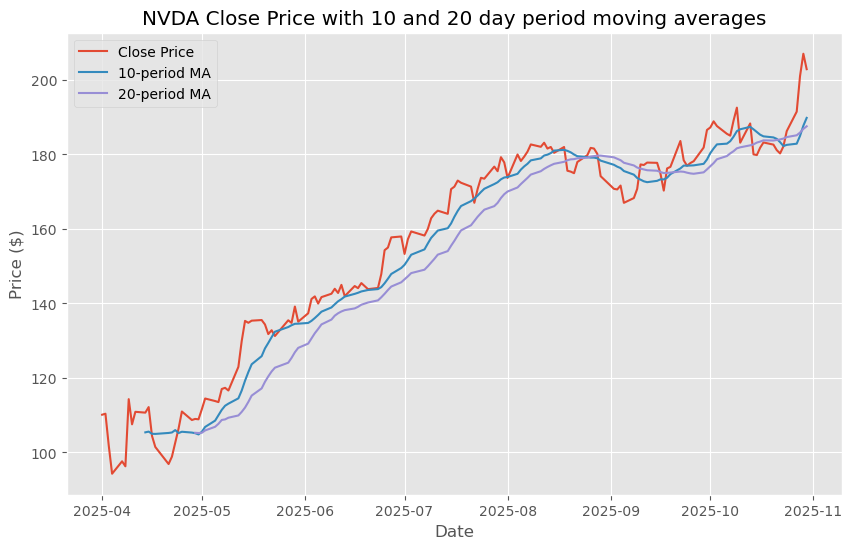

NVDA: BUY (10-day MA above 20-day MA and Close supports)


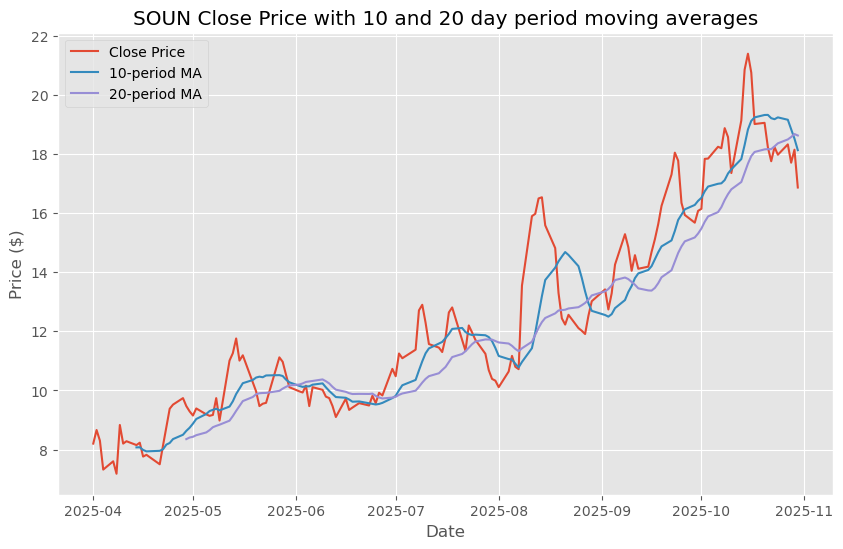

SOUN: SELL (10-day MA below 20-day MA)


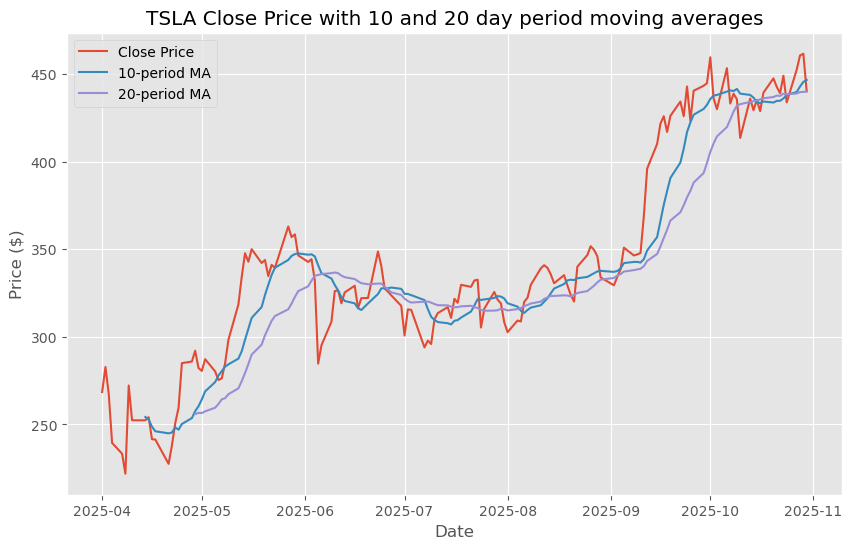

TSLA: Hold (10-day MA above 20-day MA, but Close does not support)

Total Change for Each Ticker:
  Ticker Total Change (%)
0   NVDA           86.98%
1   SOUN          103.99%
2   TSLA           66.83%


C:\Users\leonc\AppData\Local\Temp\ipykernel_13976\2184281055.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g["Close"].iloc[-1] - g["Open"].iloc[0]) / g["Open"].iloc[0] * 100)


In [13]:
x = analysis(["TSLA", "NVDA", "SOUN"], "2025-04-01")
style.use("ggplot")

# Plot the closing price and moving averages on the same graph
for ticker, group in x.groupby("Ticker"):
    plt.figure(figsize=(10, 6))

    # Sort by date
    group = group.sort_values("Date")

    plt.plot(group["Date"], group["Close"], label="Close Price")
    plt.plot(group["Date"], group["10DA"], label="10-period MA")
    plt.plot(group["Date"], group["20DA"], label="20-period MA")
    
    # create title and labels 
    plt.title(f"{ticker} Close Price with 10 and 20 day period moving averages")
    plt.xlabel("Date")
    plt.ylabel("Price ($)")
    plt.legend()
    plt.show()

    # get rid of all blank values in the moving averages and compare last values in 5DA, 20DA, and closing price
    valid = group.dropna(subset=["10DA", "20DA"])
    if len(valid) > 0:
        last = valid.iloc[-1]
        if last["10DA"] > last["20DA"]:
            if last["Close"] > last["10DA"]:
                signal = "BUY (10-day MA above 20-day MA and Close supports)"
            else:
                signal = "Hold (10-day MA above 20-day MA, but Close does not support)"
        elif last["10DA"] < last["20DA"]:
            signal = "SELL (10-day MA below 20-day MA)"
        else:
            signal = "Hold (10-day MA = 20-day MA)"
        print(f"{ticker}: {signal}")
    else:
        print(f"{ticker}: not enough data to compute moving averages.")
tot_change(x)

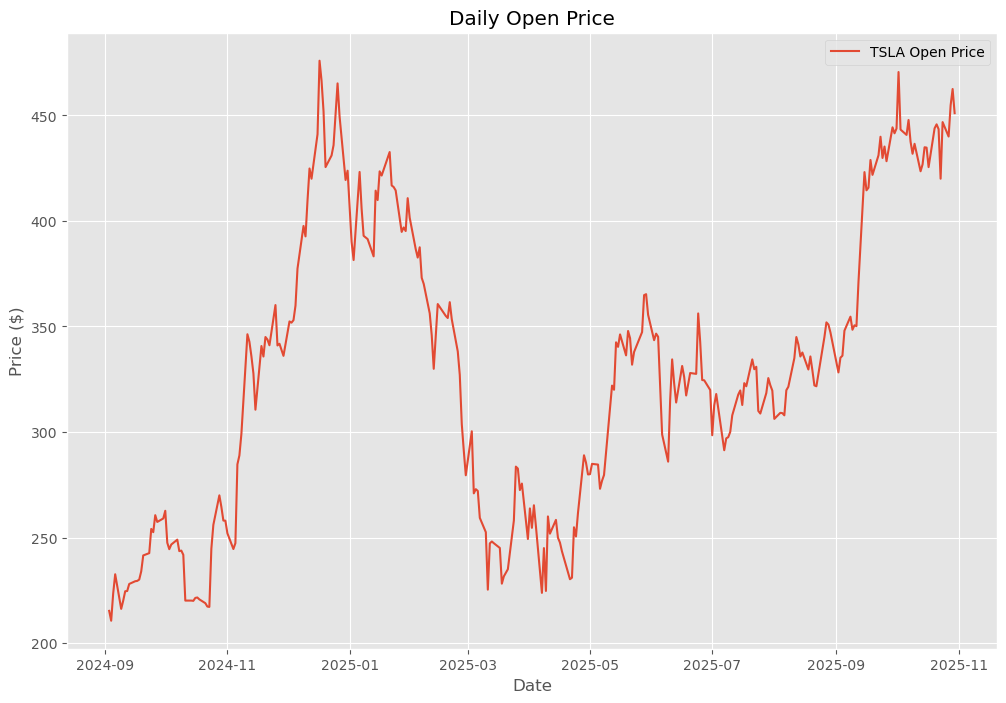

In [14]:
x = analysis(["TSLA"])

# Convert formatted strings back to numeric values
x["Open"] = x["Open"].replace('[\$,]', '', regex=True).astype(float)


# Plot
style.use("ggplot")
plt.figure(figsize=(12, 8))

for ticker, group in x.groupby("Ticker"):
    plt.plot(group["Date"], group["Open"], label=f"{ticker} Open Price")

plt.title("Daily Open Price")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.show()

In [20]:
industry_results = {}
top_per_industry = {}

for industry, tickers in industry_dict.items():
    print(f"\n=== {industry} ===")

    # Run your analysis() on the tickers in this industry
    final = analysis(tickers)
    industry_results[industry] = final

    # Compute total change for this industry
    changes = tot_change(final)

    # Pick the top 1 ticker
    top = (
        changes.sort_values("Total Change (%)", ascending=False)
               .iloc[0]
    )

    top_per_industry[industry] = top["Ticker"]

# Show results
print("\nTop ticker in each industry:")
top_ticks =[]
for ind, tick in top_per_industry.items():
    top_ticks.append(tick)
    print(f"{ind}: {tick}")


=== Communication Services ===


C:\Users\leonc\AppData\Local\Temp\ipykernel_13976\355076041.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g["Close"].iloc[-1] - g["Open"].iloc[0]) /



=== Consumer Discretionary ===


C:\Users\leonc\AppData\Local\Temp\ipykernel_13976\355076041.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g["Close"].iloc[-1] - g["Open"].iloc[0]) /



=== Consumer Staples ===



1 Failed download:
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2024-09-01 -> 2025-10-31)')
C:\Users\leonc\AppData\Local\Temp\ipykernel_13976\355076041.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g["Close"].iloc[-1] - g["Open"].iloc[0]) /



=== Energy ===


C:\Users\leonc\AppData\Local\Temp\ipykernel_13976\355076041.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g["Close"].iloc[-1] - g["Open"].iloc[0]) /



=== Financials ===



1 Failed download:
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')
C:\Users\leonc\AppData\Local\Temp\ipykernel_13976\355076041.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g["Close"].iloc[-1] - g["Open"].iloc[0]) /



=== Health Care ===


C:\Users\leonc\AppData\Local\Temp\ipykernel_13976\355076041.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g["Close"].iloc[-1] - g["Open"].iloc[0]) /



=== Industrials ===


C:\Users\leonc\AppData\Local\Temp\ipykernel_13976\355076041.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g["Close"].iloc[-1] - g["Open"].iloc[0]) /



=== Information Technology ===


C:\Users\leonc\AppData\Local\Temp\ipykernel_13976\355076041.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g["Close"].iloc[-1] - g["Open"].iloc[0]) /



=== Materials ===


C:\Users\leonc\AppData\Local\Temp\ipykernel_13976\355076041.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g["Close"].iloc[-1] - g["Open"].iloc[0]) /



=== Real Estate ===


C:\Users\leonc\AppData\Local\Temp\ipykernel_13976\355076041.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g["Close"].iloc[-1] - g["Open"].iloc[0]) /



=== Utilities ===

Top ticker in each industry:
Communication Services: WBD
Consumer Discretionary: TPR
Consumer Staples: MNST
Energy: EQT
Financials: HOOD
Health Care: CAH
Industrials: GEV
Information Technology: APP
Materials: NEM
Real Estate: WELL
Utilities: VST


C:\Users\leonc\AppData\Local\Temp\ipykernel_13976\355076041.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g["Close"].iloc[-1] - g["Open"].iloc[0]) /


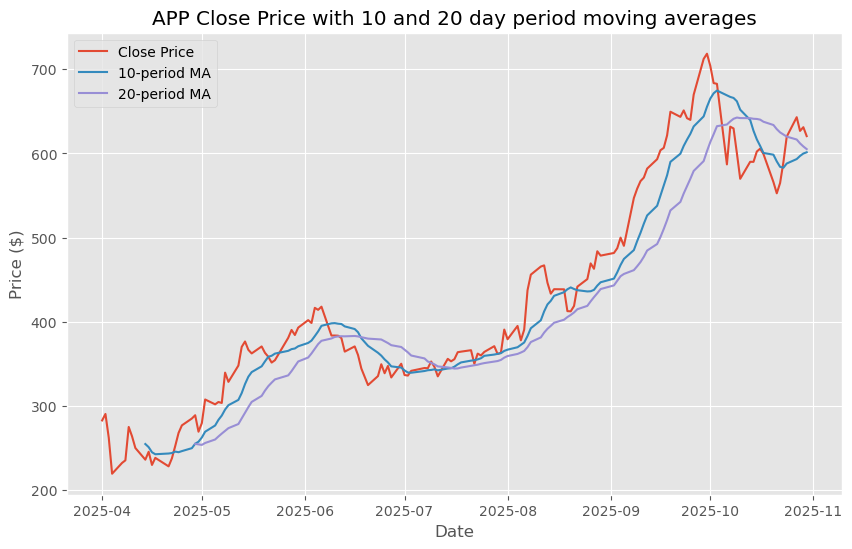

APP: SELL (10-day MA below 20-day MA)


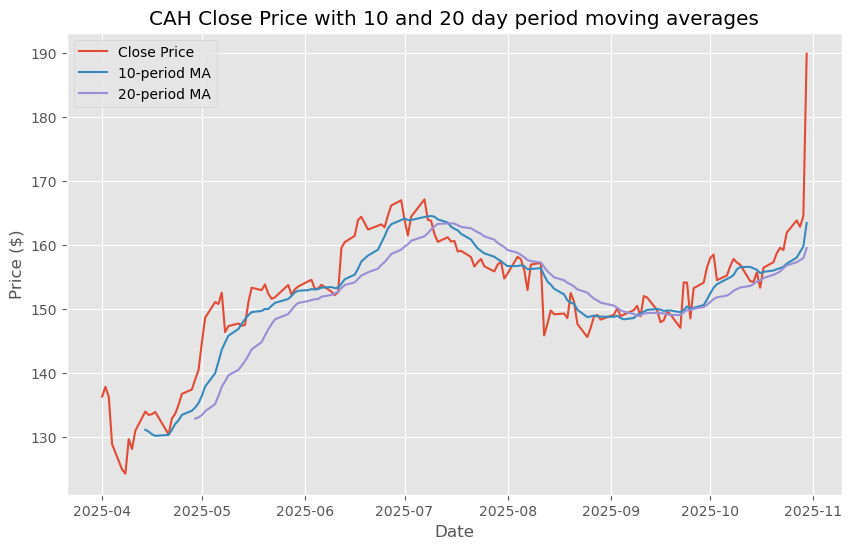

CAH: BUY (10-day MA above 20-day MA and Close supports)


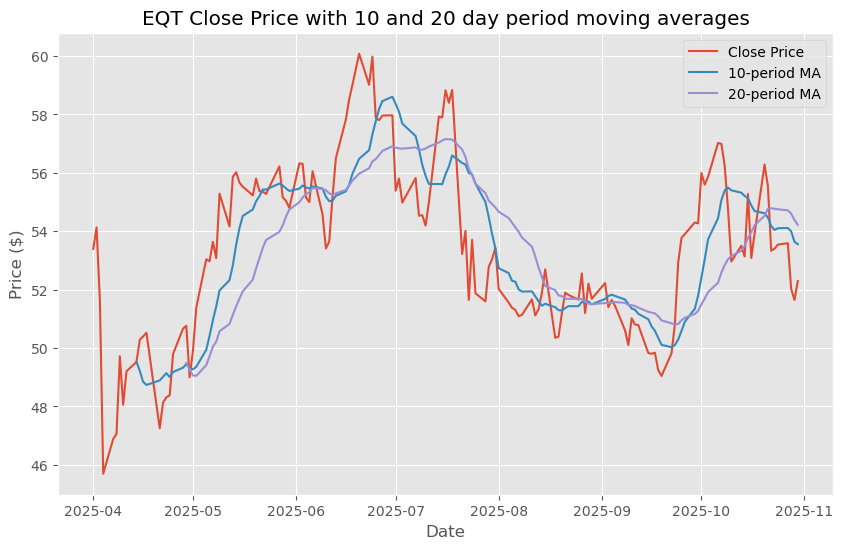

EQT: SELL (10-day MA below 20-day MA)


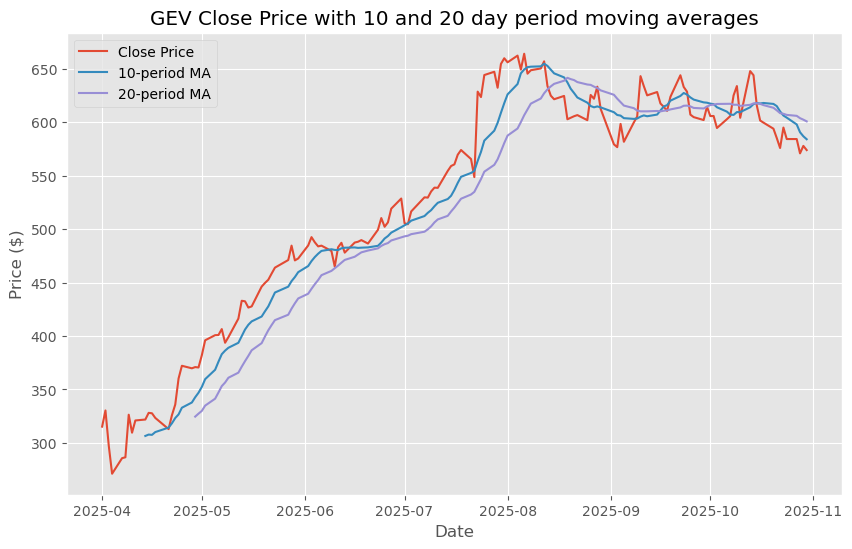

GEV: SELL (10-day MA below 20-day MA)


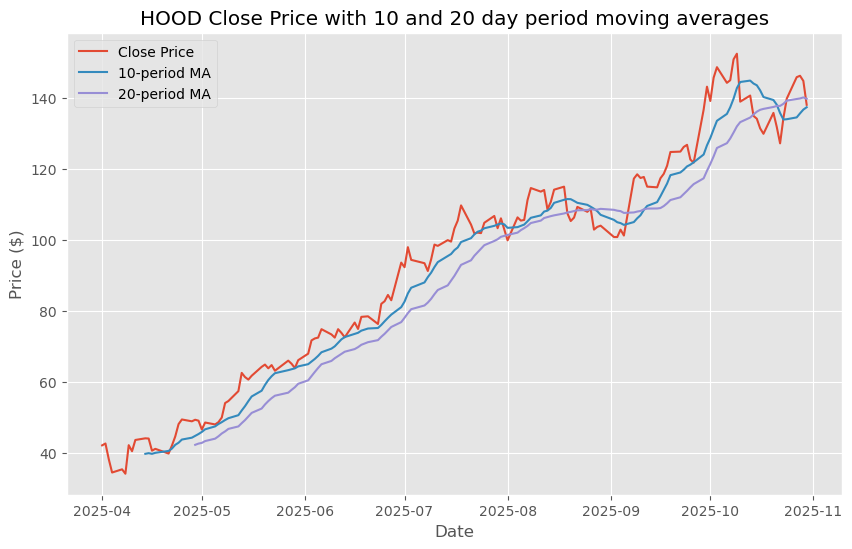

HOOD: SELL (10-day MA below 20-day MA)


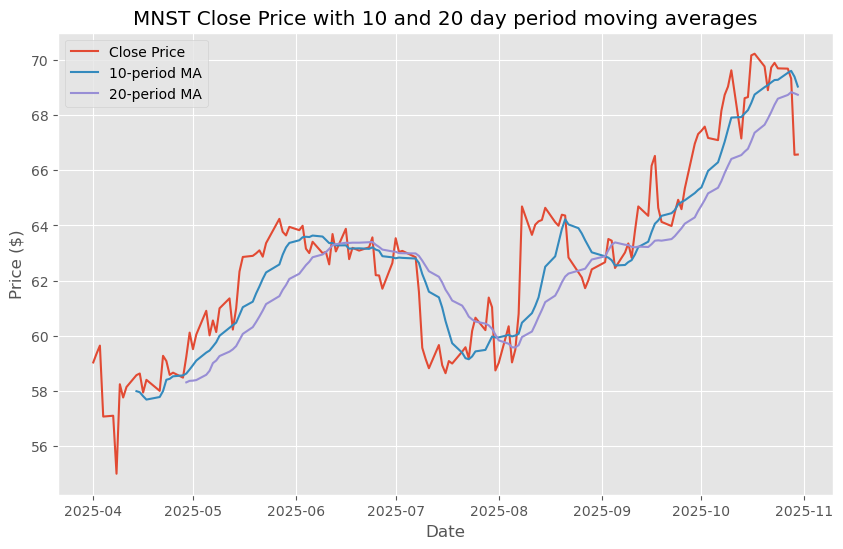

MNST: Hold (10-day MA above 20-day MA, but Close does not support)


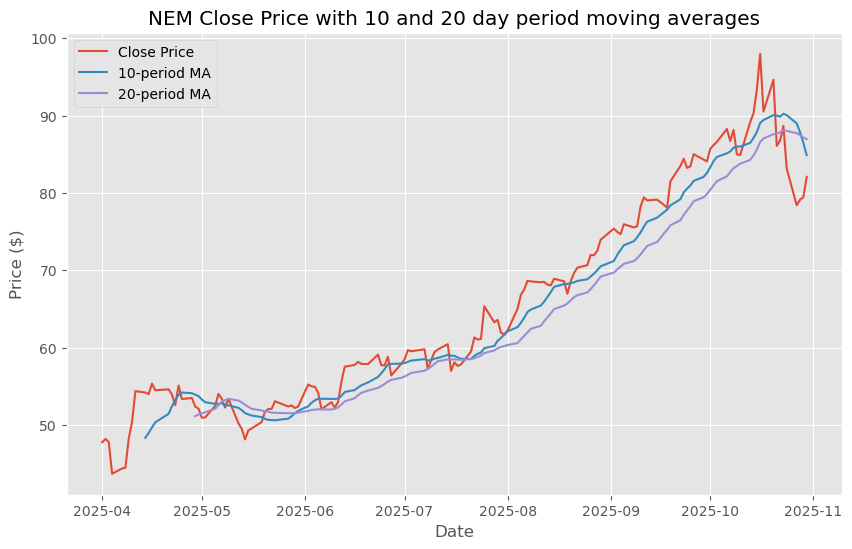

NEM: SELL (10-day MA below 20-day MA)


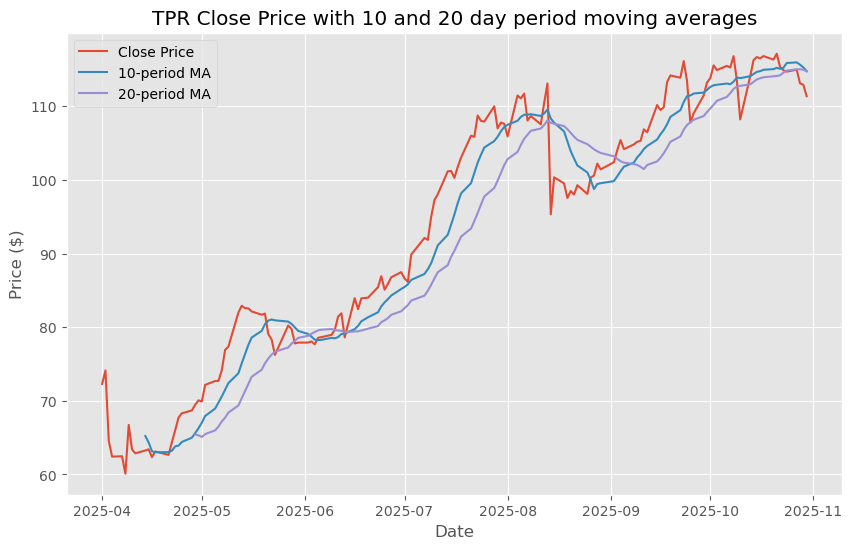

TPR: SELL (10-day MA below 20-day MA)


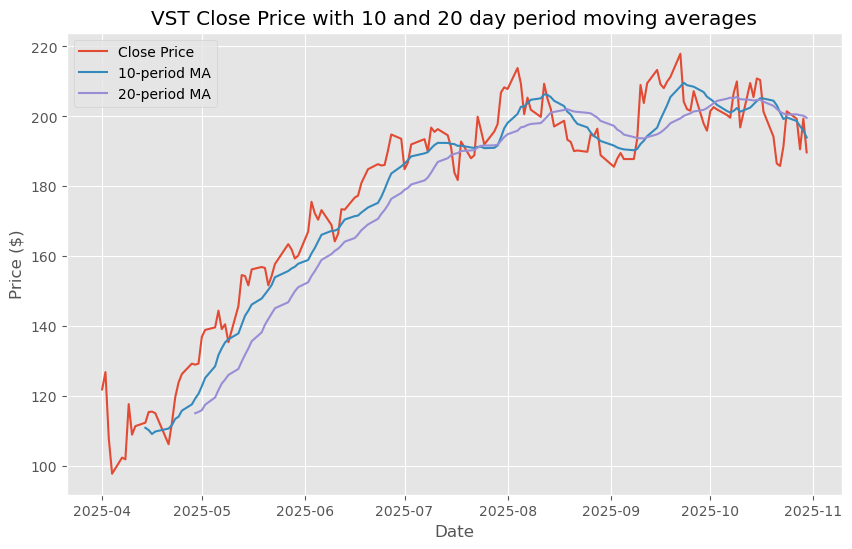

VST: SELL (10-day MA below 20-day MA)


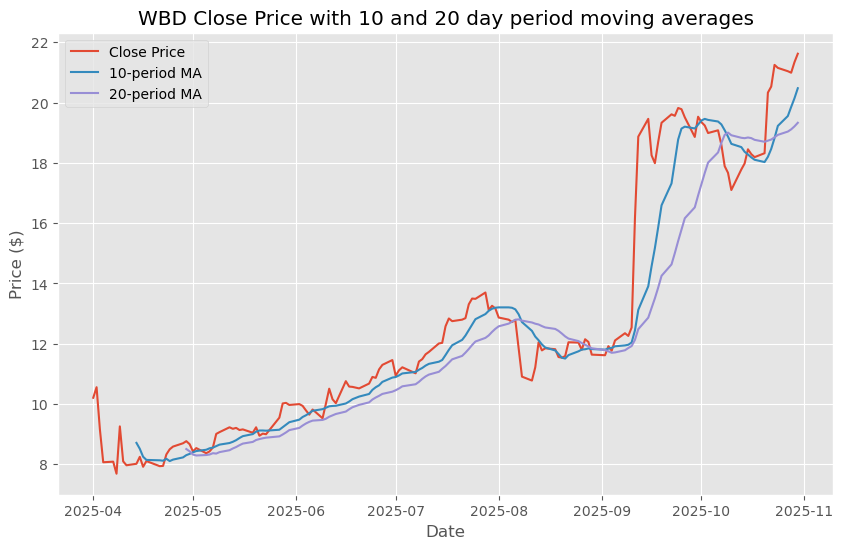

WBD: BUY (10-day MA above 20-day MA and Close supports)


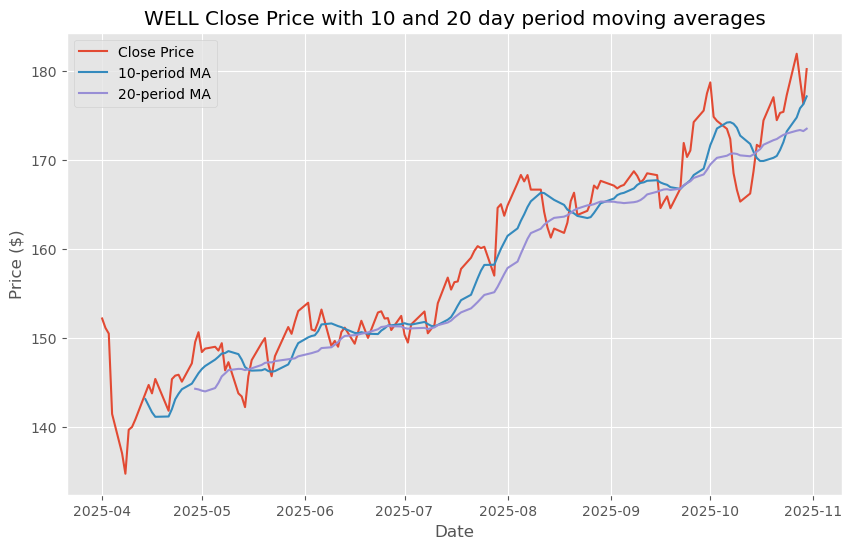

WELL: BUY (10-day MA above 20-day MA and Close supports)


C:\Users\leonc\AppData\Local\Temp\ipykernel_13976\355076041.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g["Close"].iloc[-1] - g["Open"].iloc[0]) /


,Ticker,Total Change (%)
0,APP,134.887591
1,CAH,38.878409
2,EQT,-1.682880
3,GEV,86.930218
4,HOOD,230.311028
5,MNST,13.794871
6,NEM,71.532704
7,TPR,59.591647
8,VST,60.766770
9,WBD,100.370722


In [21]:
x = analysis(top_ticks, "2025-04-01")
style.use("ggplot")

# Plot the closing price and moving averages on the same graph
for ticker, group in x.groupby("Ticker"):
    plt.figure(figsize=(10, 6))

    # Sort by date
    group = group.sort_values("Date")

    plt.plot(group["Date"], group["Close"], label="Close Price")
    plt.plot(group["Date"], group["10DA"], label="10-period MA")
    plt.plot(group["Date"], group["20DA"], label="20-period MA")
    
    # create title and labels 
    plt.title(f"{ticker} Close Price with 10 and 20 day period moving averages")
    plt.xlabel("Date")
    plt.ylabel("Price ($)")
    plt.legend()
    plt.show()

    # get rid of all blank values in the moving averages and compare last values in 5DA, 20DA, and closing price
    valid = group.dropna(subset=["10DA", "20DA"])
    if len(valid) > 0:
        last = valid.iloc[-1]
        if last["10DA"] > last["20DA"]:
            if last["Close"] > last["10DA"]:
                signal = "BUY (10-day MA above 20-day MA and Close supports)"
            else:
                signal = "Hold (10-day MA above 20-day MA, but Close does not support)"
        elif last["10DA"] < last["20DA"]:
            signal = "SELL (10-day MA below 20-day MA)"
        else:
            signal = "Hold (10-day MA = 20-day MA)"
        print(f"{ticker}: {signal}")
    else:
        print(f"{ticker}: not enough data to compute moving averages.")


In [23]:
print(industry_results)

{'Communication Services': Price       Date Ticker        Open       Close  % Change    10DA     20DA
0     2024-09-03  GOOGL  160.796576  156.461472 -2.696018     NaN      NaN
1     2024-09-04  GOOGL  155.765479  155.556671 -0.134053     NaN      NaN
2     2024-09-05  GOOGL  155.407543  156.342178  0.601409     NaN      NaN
3     2024-09-06  GOOGL  156.401818  150.058243 -4.055947     NaN      NaN
4     2024-09-09  GOOGL  151.840387  148.057083 -2.491632     NaN      NaN
...          ...    ...         ...         ...       ...     ...      ...
6711  2025-10-24    WBD   21.370001   21.150000 -1.029486  19.227  18.9290
6712  2025-10-27    WBD   21.049999   21.040001 -0.047498  19.553  19.0380
6713  2025-10-28    WBD   21.370001   20.990000 -1.778199  19.854  19.1110
6714  2025-10-29    WBD   20.920000   21.340000  2.007649  20.143  19.2105
6715  2025-10-30    WBD   21.469999   21.620001  0.698656  20.476  19.3295

[6716 rows x 7 columns], 'Consumer Discretionary': Price       Date Tick